In [15]:
import yfinance as yf
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import kpss

In [16]:
def get_finance_data(stock):
    s = yf.Ticker(stock)
    
    df = s.history(start = '2009-01-31', end='2021-01-31', interval = "1d")
    df = df.drop(['Dividends', 'Stock Splits'], axis=1)

    return df

In [17]:
aapl = get_finance_data('AAPL')

In [22]:
aapl = aapl.asfreq('D')

In [23]:
aapl.isna().sum()

Open      1360
High      1360
Low       1360
Close     1360
Volume    1360
dtype: int64

In [24]:
aapl = aapl.fillna(method='ffill')

In [25]:
aapl.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [27]:
aapl.index

DatetimeIndex(['2009-02-02', '2009-02-03', '2009-02-04', '2009-02-05',
               '2009-02-06', '2009-02-07', '2009-02-08', '2009-02-09',
               '2009-02-10', '2009-02-11',
               ...
               '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-23',
               '2021-01-24', '2021-01-25', '2021-01-26', '2021-01-27',
               '2021-01-28', '2021-01-29'],
              dtype='datetime64[ns]', name='Date', length=4380, freq='D')

In [28]:
aapl_close = aapl[['Close']]

In [31]:
aapl_close.head()

,Close
Date,
2009-02-02,2.806142
2009-02-03,2.851219
2009-02-04,2.868699
2009-02-05,2.957933
2009-02-06,3.057901


## ARIMA building

In [37]:
from numpy import log
result = adfuller(aapl_close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.845936
p-value: 1.000000


C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


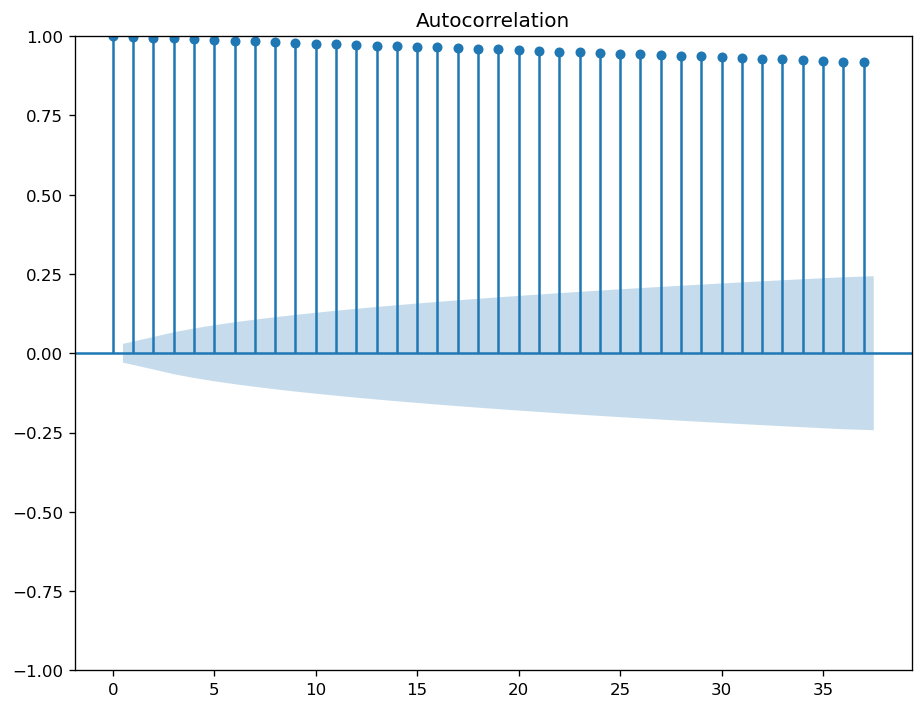

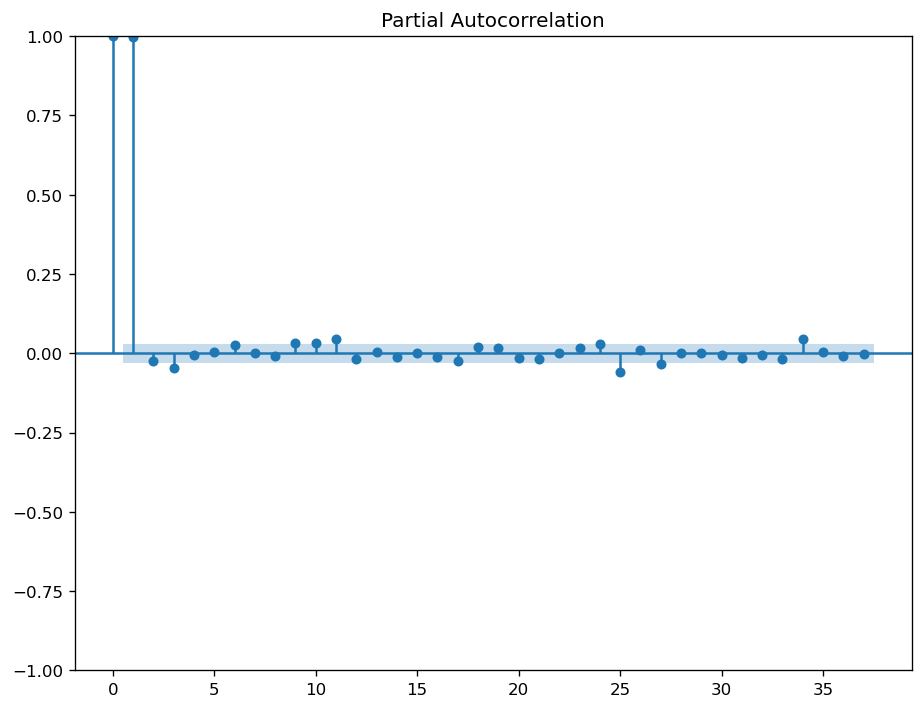

In [43]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data

# Original Series
plot_acf(aapl_close)

plot_pacf(aapl_close)

plt.show()

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


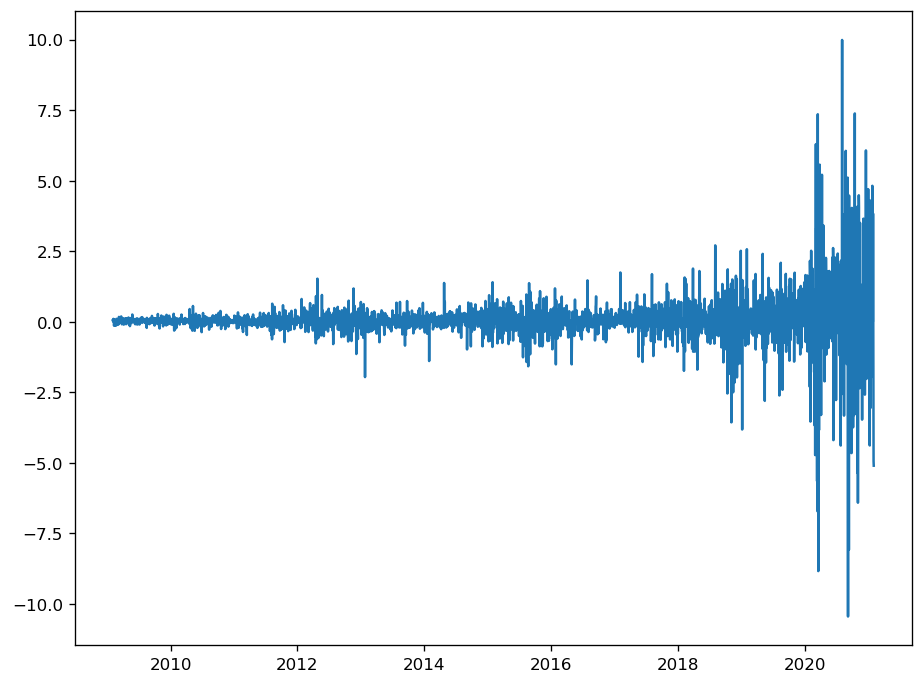

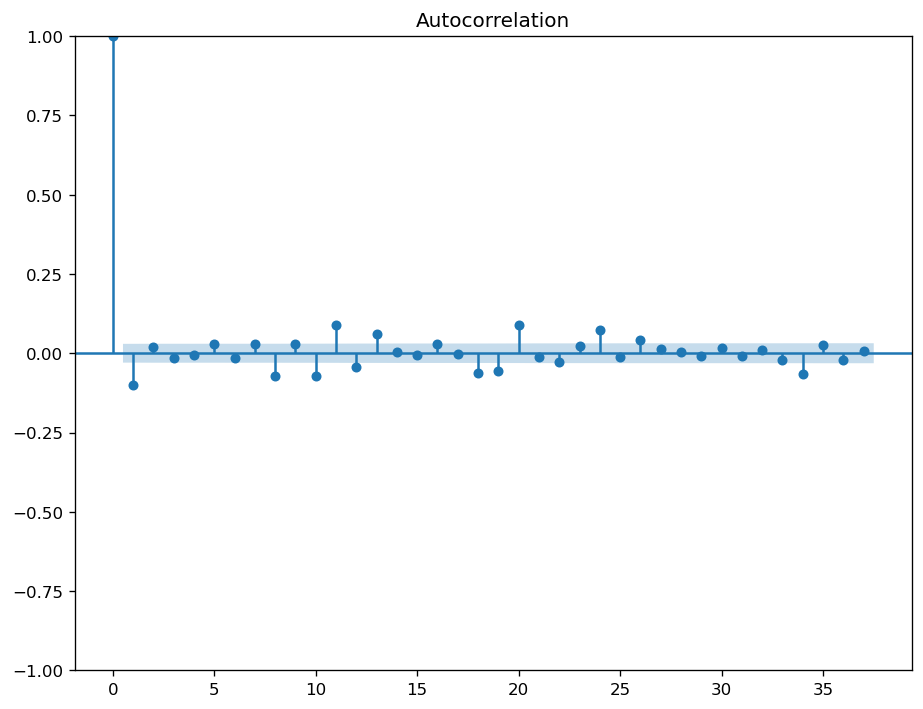

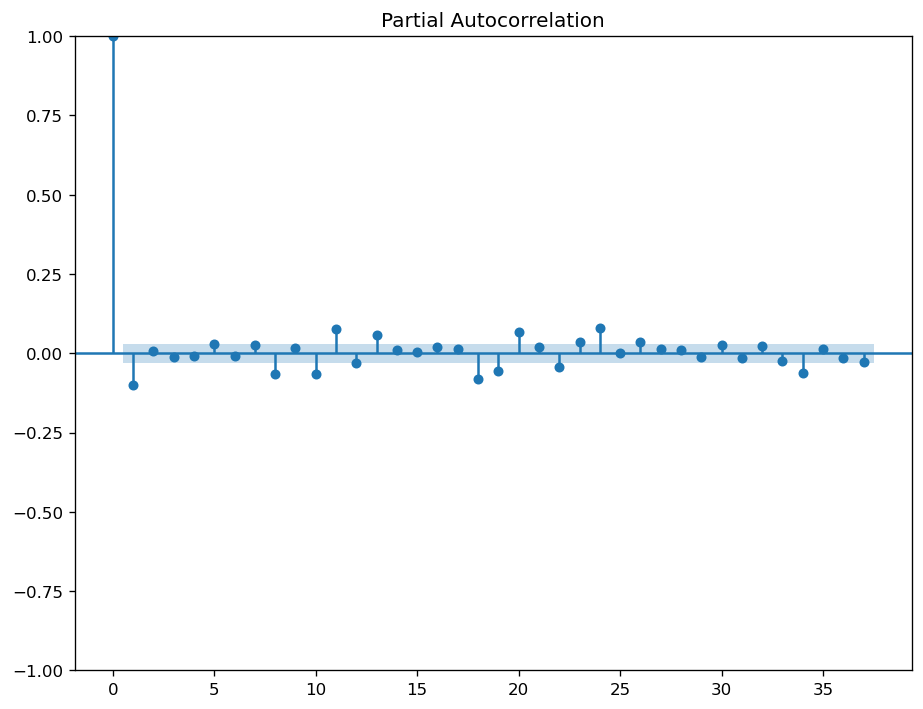

In [48]:
plt.plot(aapl_close.diff().dropna());

plot_acf(aapl_close.diff().dropna());

plot_pacf(aapl_close.diff().dropna());

In [101]:
model = SARIMAX(aapl_close, order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4380
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -4879.399
Date:                Fri, 15 Oct 2021   AIC                           9762.798
Time:                        05:17:08   BIC                           9775.567
Sample:                    02-02-2009   HQIC                          9767.303
                         - 01-29-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0962      0.005    -19.054      0.000      -0.106      -0.086
sigma2         0.5437      0.002    231.475      0.000       0.539       0.548
Ljung-Box (L1) (Q):                   0.06   Jarque-

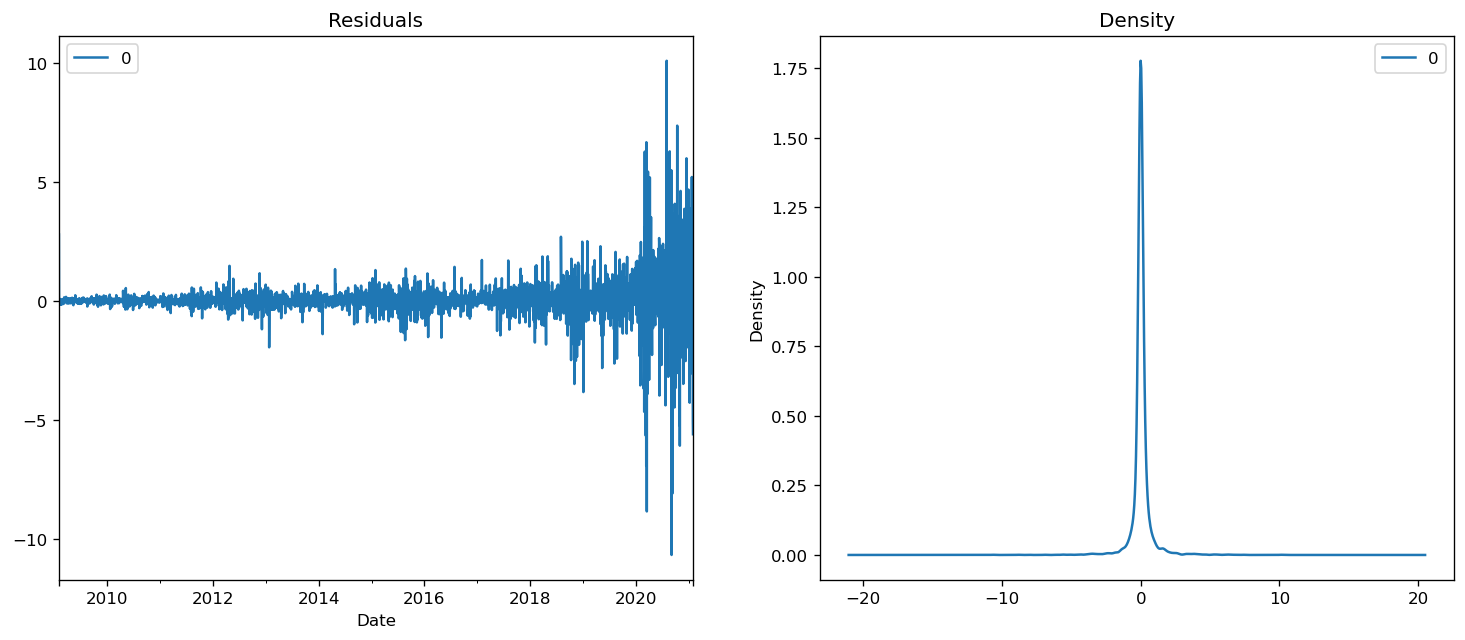

In [102]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [126]:
n = int(len(aapl_close) * 0.8)
train = aapl_close[:n]
test = aapl_close[n:]

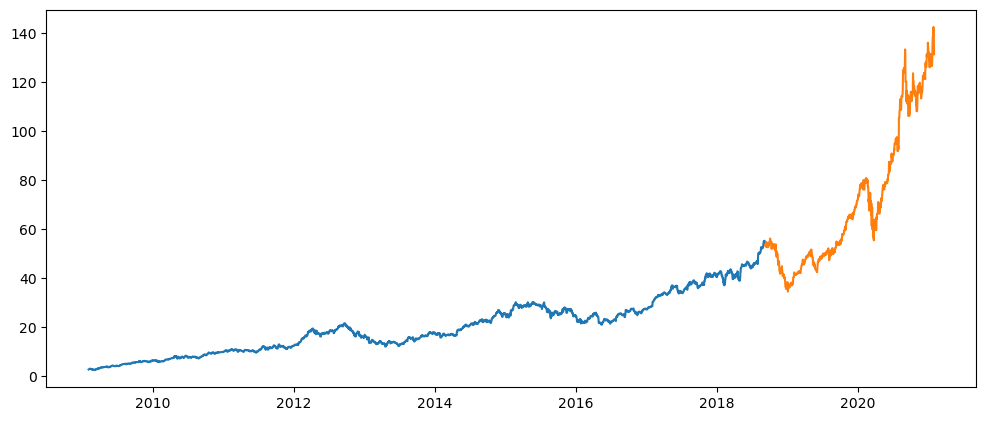

In [127]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')

## Prediction

In [128]:
pred = model_fit.predict(start=pd.to_datetime('2018-09-07'), dynamic=False)
plt.show()

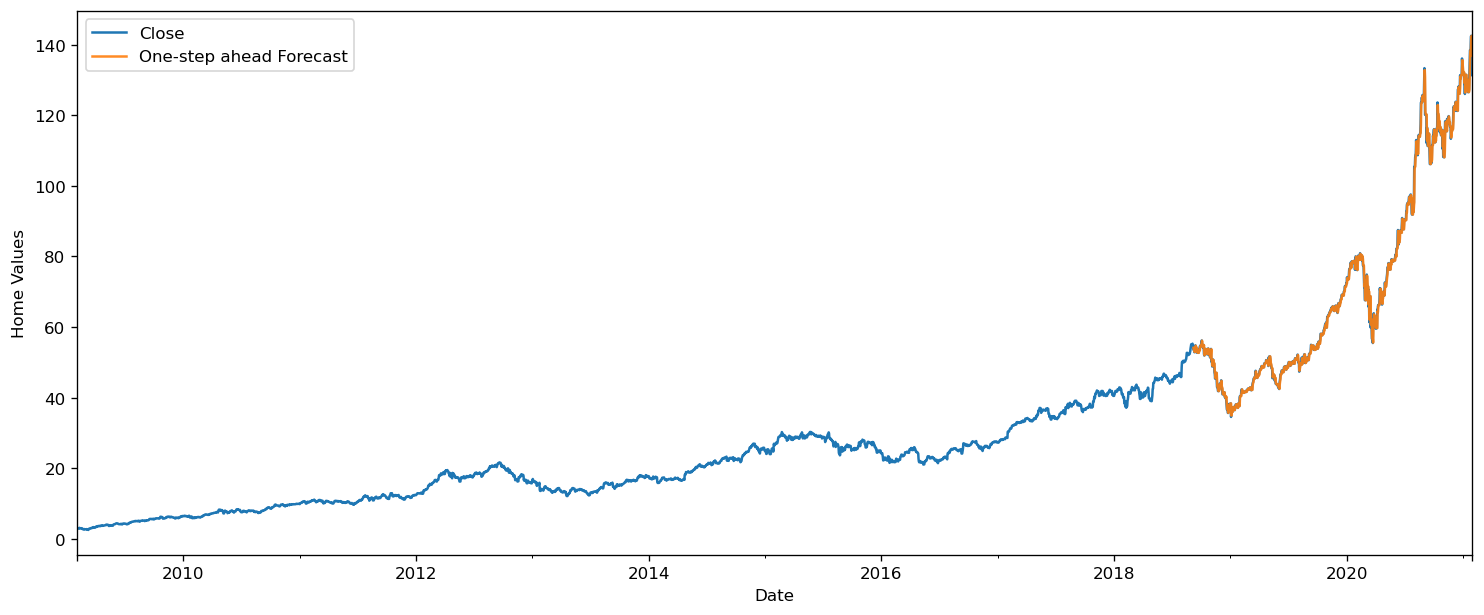

In [129]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = aapl_close.plot(label='observed')

# Plot predicted values
pred.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Values')
plt.legend()

plt.show();


In [134]:
value_forecasted = pred
value_truth = aapl_close['Close']['2018-09-07':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of prediction is 1.55


## Trying to forecast

In [132]:
prediction = model_fit.get_forecast(steps=500, dynamic=True)

# Get confidence intervals of forecast
pred_conf = prediction.conf_int()

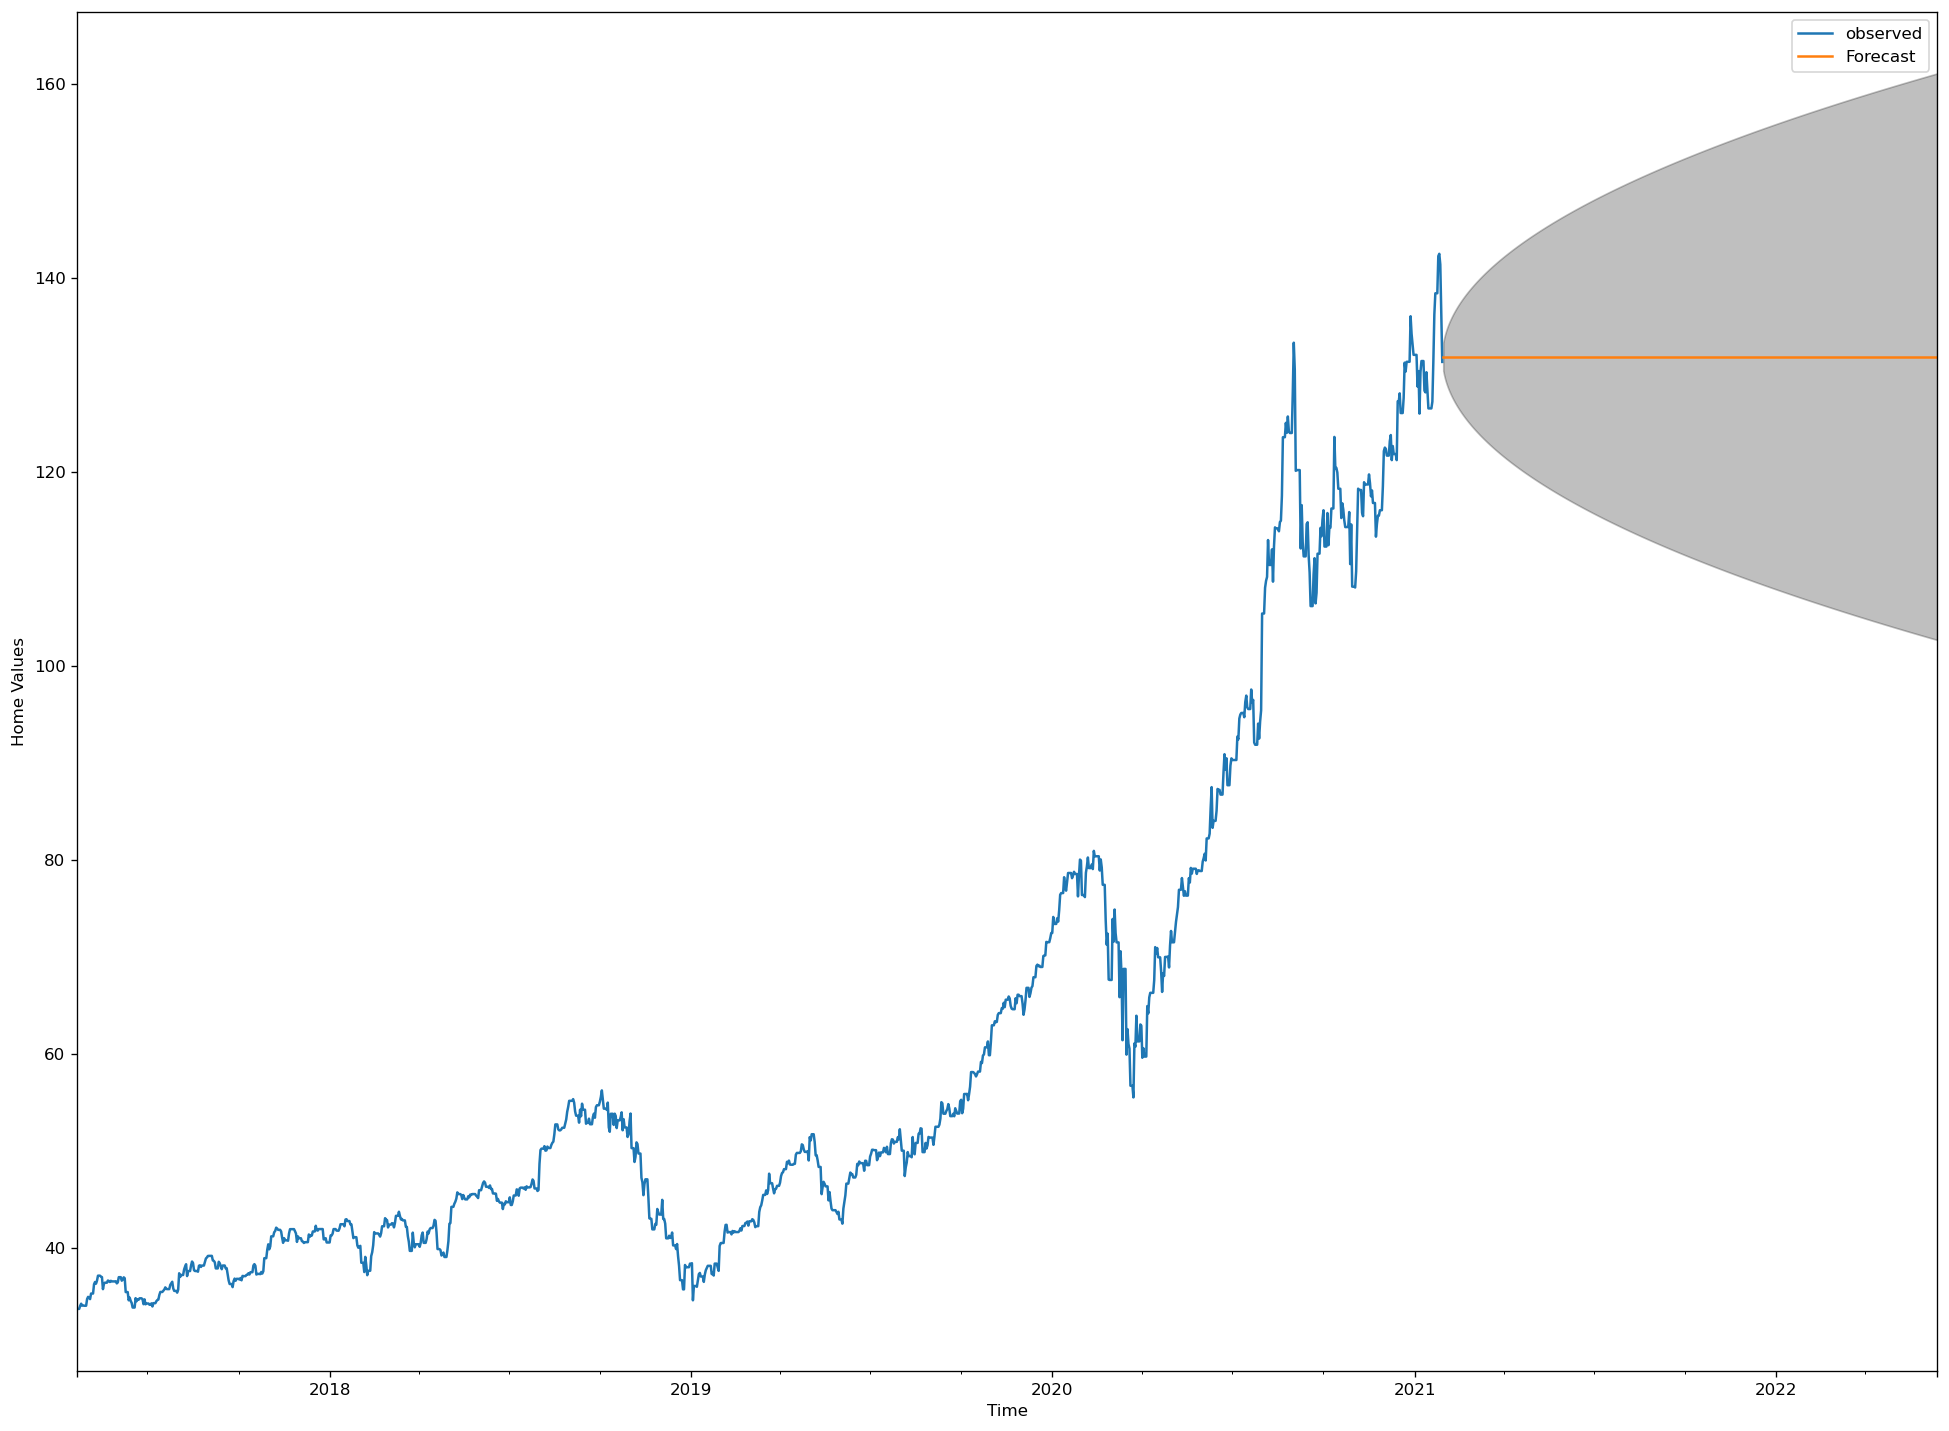

In [133]:
ax = aapl_close['Close'].iloc[3000:].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Time')
ax.set_ylabel('Home Values')
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.legend()
plt.show()